In [ ]:
!pip install tensorflow==2.16.1
!pip install keras-tuner --upgrade

In [3]:
import os
import warnings
import random
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()
matplotlib.rcParams['figure.figsize'] = [14, 3]
print(tf.__version__)

2.15.0


In [3]:
def seed(SEED=0):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed()
warnings.filterwarnings('ignore')

In [4]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='training loss')
  plt.plot(history.history['val_loss'], label='val loss')
  plt.title('Meter Demand')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  # plt.savefig('train-val.png')
  plt.show()

In [177]:
meter_demand = [27800, 29900, 29650, 26300, 36000, 25000, 30000, 32500, 30200, 26100, 23600, 25400]
meter_demand_df = pd.DataFrame(meter_demand, columns = ['meter demand'])
# df.describe()

Generate data based on mean and standard deviation

<Axes: >

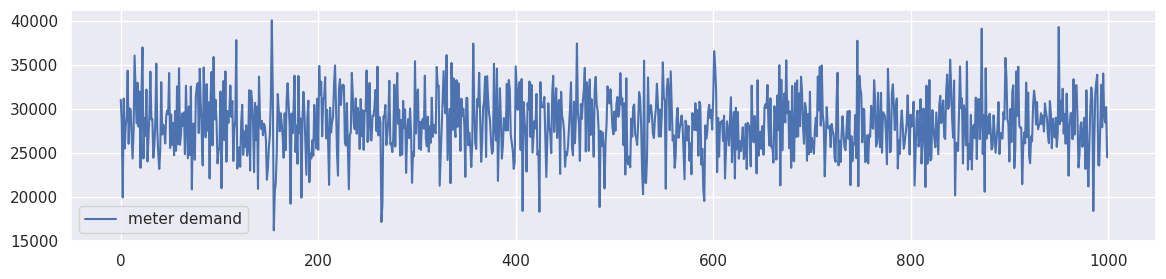

In [4]:
mean = 28537.5
std = 3537.02

samples = 1000
data = np.random.normal(mean, std, samples)

synthetic_data = pd.DataFrame(data, columns = ['meter demand'])
synthetic_data.plot()

In [7]:
date_range = pd.date_range(start='2022-01-01', periods=samples, freq='M')
date_range

DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31',
               ...
               '2104-07-31', '2104-08-31', '2104-09-30', '2104-10-31',
               '2104-11-30', '2104-12-31', '2105-01-31', '2105-02-28',
               '2105-03-31', '2105-04-30'],
              dtype='datetime64[ns]', length=1000, freq='M')

In [8]:
synthetic_data.set_index(date_range, inplace=True)
synthetic_data

,meter demand
2022-01-31,31004.614994
2022-02-28,28452.365149
2022-03-31,19918.553299
2022-04-30,31153.542436
2022-05-31,25481.991220
...,...
2104-12-31,33996.104940
2105-01-31,29171.848781
2105-02-28,28424.113206
2105-03-31,30179.839684


In [34]:
# def generate_time_series(length, trend=True, seasonal_period=24, noise_level=1):
#     time_step = np.arange(length)
#     seasonality = np.where(time_step % seasonal_period == 0, 1, 0)
#     trend_slope = 1 / length
#     trend = time_step * trend_slope
#     noise = np.random.randn(length) * noise_level
#     time_series = seasonality + trend + noise

#     return time_series

In [35]:
# length = 10000
# time_step = np.arange(length)
# synthetic_data = generate_time_series(length, seasonal_period=24, noise_level=1)

In [36]:
def create_dataset(data,time_window, label):
    X,Y=[],[]
    for i in range (len(data)-time_window-1) :

        a=data[i:i+time_window,0:data.shape[1]]
        X.append(a)
        Y.append(data[i+time_window,label])

    return (np.array(X),np.array(Y))

In [178]:
df1=np.array(synthetic_data['meter demand'])
df2 = df1.reshape(-1, 1)

In [179]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df2)

In [187]:
train_split = round(0.8*len(df_scaled))
time_window = 1

In [188]:
df1_train, df1_test= df_scaled[0:train_split],  df_scaled[train_split:]
x_train,y_train=create_dataset(df1_train[:,np.newaxis], time_window, 0)
x_test, y_test=create_dataset(df1_test[:,np.newaxis], time_window, 0)

In [189]:
model=keras.Sequential()
model.add(keras.layers.LSTM(256, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(keras.layers.Dense(1,'linear'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
               loss='mean_squared_error',
               metrics=["mae"]
               )

# model.summary()

In [190]:
# keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

In [ ]:
%%time
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_split=0.1,
    # verbose=0
    )

In [ ]:
plot_loss(history)

In [ ]:
score = model.evaluate(x_test, y_test)
score

In [ ]:
y_pred = model.predict(y_test)

In [ ]:
plt.plot(y_pred)
plt.plot(y_test)

In [ ]:
Y_pred = scaler.inverse_transform(y_pred)
Y_pred

In [ ]:
Y = scaler.inverse_transform(y_test)

In [ ]:
df_compare = pd.DataFrame()
df_compare['Y_pred'] = Y_pred.squeeze()
df_compare['Y'] = Y.squeeze()
df_compare

In [ ]:
sns.lineplot(Y_pred, markers=["^"])
sns.lineplot(Y, markers=["o"])
# plt.title('meter demand')
plt.xlabel('time step')
plt.ylabel('meter demand')
plt.legend()
plt.savefig('train-val.png')
plt.show()

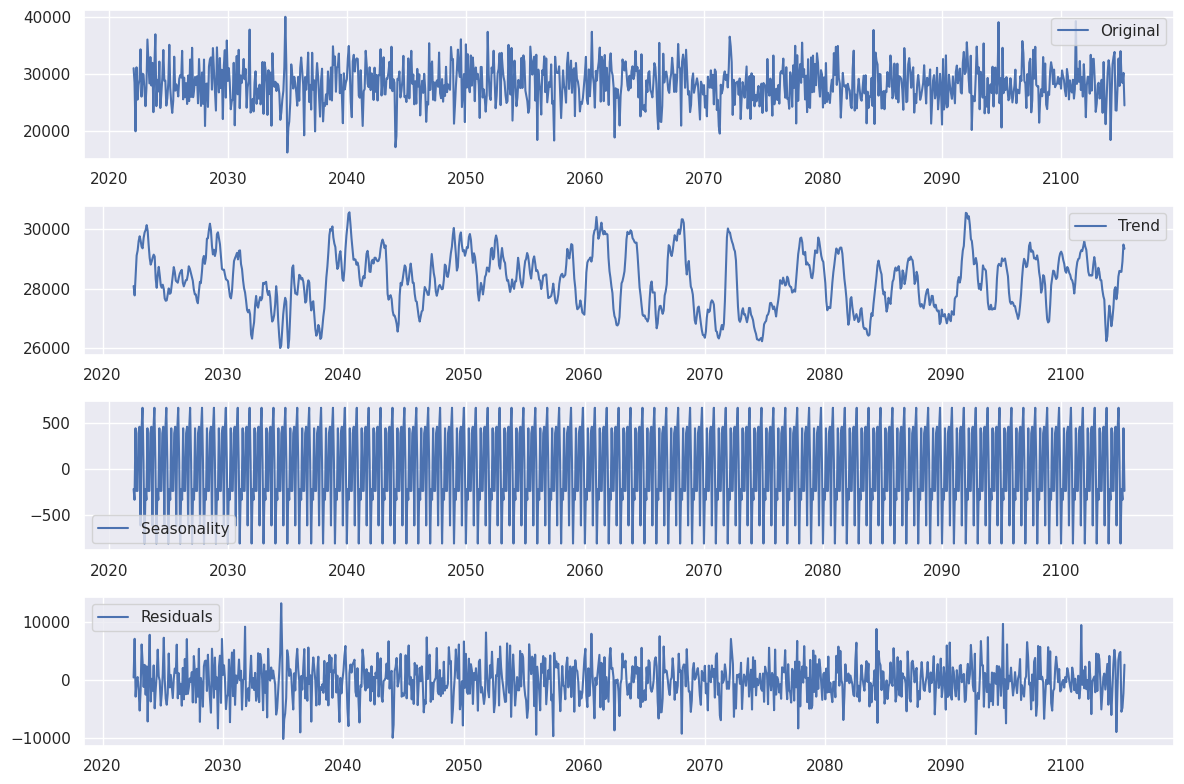

In [10]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(synthetic_data, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(synthetic_data, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()
